In [ ]:
### LSTM-RNN MTM model to predict temporal evolution of: Number of drops (Nd), Interfacial Area (IA), and size distribution (DSD)
### Code adapted for L-L SMX static mixer
### Author: Juan Pablo Valdes
### First commit: Aug, 2023
### Code adapted from: LSTM_MTM by Fuyue Liang, 2023 for stirred vessels
### Department of Chemical Engineering, Imperial College London

# **LSTM timeseries prediction for SMX dispersion performance**

In [ ]:
##All imports
import numpy as np
import pandas as pd
import Load_Clean_DF
import matplotlib.pyplot as plt

## *Loading and cleaning up raw data*

In [ ]:
cases_3D = ['b03','b06','b09','bi001','bi01','bi1','da001','da01','da1']

cases_MD = ['b06pm','b09pm','bi001pm','bi01pm','da01pm']

cases_clean = ['3drop', 'coarsepm']

Allcases = ['b03','b06','bi001','bi01','da01','da1','b06pm','b09pm','bi001pm',
'bi1','bi01pm','3drop',
'b09','da01pm','da001', 'coarsepm']

<small>Importing rawdata from pre-processed csv files into dataframes</small>

In [ ]:
def import_rawdata(case):
    if case == '3drop' or case == 'coarsepm':
        # If true, extract only volume array
        df_Vol = Load_Clean_DF.extract_Vol(case)
    else:
        # If false, extract volume and concentration arrays
        df_Vol = Load_Clean_DF.extract_GVol(case)
    
    # Extract number of drops (Nd) and interfacial area (IntA)
    Nd = Load_Clean_DF.extract_Nd(case)
    IntA = Load_Clean_DF.extract_IA(case)

    return df_Vol, Nd, IntA

<small>Storing all data into a single dictionary to be used later by the LSTM</small>

In [ ]:
# Initialize dicts to hold all data extracted from HR sims, before and after post-process
pre_dict = {}
post_dict = {}

# Loop through all cases
for case in Allcases:
    # Extract raw data
    df_Vol, Nd, IntA = import_rawdata(case)
    
    time = Nd['Time']
    n_drops = Nd['Ndrops']
    IA = IntA['IA']
    DSD = df_Vol['Volume']
    
    # Determine if case needs surf. conc. or clean
    if case == '3drop' or case == 'coarsepm':
        G = []  # If true, set G as an empty list
    else:
        G = df_Vol['Gammatilde']  # If false, extract G data
    
    pre_dict[case] = {'Time': time, 'Nd': n_drops, 'IA': IA, 'Vol': DSD, 'G': G}
    
    # Initialize an empty post-process dict per case
    post_dict[case] = {}



### Starting first with Nd and IA

<small>Scale and normalise data to be handled for LSTM</small>

In [ ]:
# Import MinMaxScaler from sklearn for scaling and normalization
from sklearn.preprocessing import MinMaxScaler

# List of columns to be normalized
norm_columns = ['Nd', 'IA']

for case in Allcases:
    norm_data_case = pre_dict[case]

    # Loop through each column to be normalized
    for column in norm_columns:
        norm_data = norm_data_case[column].values.astype('float64')
        
        # Reshape the data to be compatible with the scaler
        norm_data = norm_data.reshape(-1, 1)
        
        # Create a MinMaxScaler and fit it to the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(norm_data)
        
        # Transform and store the normalized data in the post_data dict.
        post_dict[case][column] = scaler.transform(norm_data).astype('float32')

<small>Stacking all data into a numpy array and reshaping it as : (timesteps, num_cases, num_features)</small>

In [ ]:
array = []
### All cases must have the same number of data points for them to be used in LSTM

min_length = min(len(data['IA']) for data in post_dict.values())

# Iterate through each case
for case, features in post_dict.items():
    # Extract the 'Nd' and 'IA' data for the current case
    # Cases are truncated with the min length in order to be stacked as a nparray
    Nd_data = features['Nd'][:min_length]
    IA_data = features['IA'][:min_length]

    
    # Combine 'Nd_data' and 'IA_data' into a single numpy array
    combined_data = np.column_stack((Nd_data, IA_data))
    
    # Append the combined data to the data_list
    array.append(combined_data)

# Stack the data_list along a new axis to create the final numpy array
mydata = np.stack(array, axis=1)
print('(time_step, num_case, num_feature)=', mydata.shape)

In [ ]:
### looping over the number of features (Nd and IA)
for i in range(mydata.shape[-1]):
    plt.figure()
    plt.title(f'Feature {str(i+1)}')
    ### Feature 1 and 2 being Nd and IA, respectively
    for case, idx in zip(Allcases, range(len(Allcases))):
        plt.plot(mydata[:,idx,i], label = f'{str(case)}')

plt.legend()
plt.show()

### Smoothing the processed data

In [ ]:
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

def smoothing(data, method, window_size=None, poly_order=None, lowess_frac = None):
    '''
    Input array : 2D array per feature, with shape (times, cases)
    Three methods to smooth:
    
    'moveavg': requires window_size
    'savgol': requires window_size, poly_order
    'lowess': requires lowess_frac
    '''

    ## rolling window averaging method
    if method == 'moveavg':
        if window_size is None:
            raise ValueError('Window size required')
        smoothed_data = pd.DataFrame(data).rolling(window_size, axis = 0).mean()
        smoothed_data.fillna(pd.DataFrame(data),inplace=True)
    ## SavGol filter based on fitting least-squares polynomial to a window of data points
    elif method == 'savgol':
        if window_size is None or poly_order is None:
            raise ValueError('Mising input arguments: Windowsize/polyorder')
        smoothed_data = np.apply_along_axis(
                    lambda col: savgol_filter(col, window_size, poly_order),
                    axis = 0, arr=data)
    ## Locally Weighted Scatterplot Smoothing, locally fitting linear regressions
    elif method == 'lowess':
        if lowess_frac is None:
            raise ValueError('Lowess fraction required')
        smoothed_data = np.apply_along_axis(
                    lambda col: lowess(col,np.arange(len(col)),frac = lowess_frac,return_sorted=False),
                    axis = 0, arr = data)
    else:
        raise ValueError('Unsupported smoothing method')
    
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(data)
    ax[0].set_title('Before')
    ax[1].plot(smoothed_data)
    ax[1].set_title('After')
    fig.suptitle(f'{method}', fontsize=18)
    plt.show()

    return smoothed_data

In [ ]:
data = mydata[:,:,0] # 0 for drop number and 1 for IA
#smoothed_data = smoothing(data,'lowess',lowess_frac=0.06)
smoothed_data = smoothing(data,'savgol',window_size=5,poly_order=3)
#smoothed_data = smoothing(data,'moveavg',window_size=5)

## *Train, validation and test data set splitting*

In [ ]:
### split by case
def cases_split(df, train_frac, test_frac, cases):
    '''
    input shape: (times, cases, features)
    
    return train, val data and cases
    '''
    train_size = int(df.shape[1]*train_frac)

    val_size = int(df.shape[1]*(1-test_frac-train_frac))
    
    train, val, test = df[:, :train_size, :], df[:, train_size:(train_size+val_size), :], df[:,(train_size+val_size):,:]
    print(f'number of train, val and test cases: {train.shape[1]}, {val.shape[1]}, {test.shape[1]}')
    
    train_cases, val_cases , test_cases = cases[:train_size], cases[train_size:(train_size+val_size)], cases[(train_size+val_size):]
    print(f'training cases: {train_cases}, validation cases: {val_cases}, test cases: {test_cases}')
        
    return train, val, test, train_cases, val_cases, test_cases

In [ ]:
train_frac = 0.5625
val_frac = 0.1875
test_frac = 0.25

mydata[:,:,0] = smoothed_data

f_data = mydata

train, val, test, train_cases, val_cases, test_cases = cases_split(f_data, train_frac=train_frac, test_frac = test_frac, cases=Allcases)

print(f'train, val, test shapes: {train.shape}, {val.shape}, {test.shape}')


In [ ]:
fig1 = plt.figure()
plt.plot(train[:,:,0])
plt.title('training')
fig1 = plt.figure()
plt.plot(val[:,:,0])
plt.title('val')
fig1 = plt.figure()
plt.plot(test[:,:,0])
plt.title('test')
plt.show()

## *Sampling prediction dataset (windowing)*

In [ ]:
import torch

def window_data(df, steps_in, stride, steps_out):
    '''
    
    df: with shape (times, cases, features)
    stride: the step size between consecutive windows
    pred_times:(<window_size) predicted future times from current window
    window size: Encompasses both steps_in and steps_out, referring to input seq and prediction seq
    
    lookback period = window_size - steps_out
     
    '''
    window_size = steps_in + steps_out
    casebatch_lens = [] # List to contain the number of rows/windows per case used for input-->prediction based on the steps_in - steps_out parameters
                        # Can be calculated as: len(timesteps)-window_size+1
    X, y = [], []

    for i in range(df.shape[1]): # looping for each case, df shape of (times, cases, features)
        df_case = df[:,i,:] # df per case
        for j in range(0, len(df_case)-window_size+1, stride): # Looping over timesteps based on the window size
            wd_data = df_case[j:j+window_size] # window with times: steps_in + steps_out
            X.append(wd_data[:-steps_out]) #input values, steps_in
            y.append(wd_data[-steps_out:]) #training/ prediction values, steps_out
        casebatch_lens.append(len(X)) # appending casebatch length per case 

    ## number of windows with size (steps_in) per case, used to later plot per case
    print(casebatch_lens)
    
    return torch.tensor(X), torch.tensor(y), np.array(casebatch_lens)

    


In [ ]:
steps_in, steps_out = 25, 25
wid_size = steps_in + steps_out
stride = 1

### Creating the tensors (sampling) after splitting train and validation data sets
X_train, y_train, train_casebatch = window_data(train, steps_in=steps_in, stride=stride, steps_out=steps_out)
X_val, y_val, val_casebatch = window_data(val, steps_in=steps_in, stride=stride, steps_out=steps_out)

# Check the shape of the output tensor
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
## output shape should be (windows among all cases: 
# number of windows/rows per case X number of cases, times per 
# input/prediction row: steps_in/steps_out, features per case)


# LSTM MTM (Many-to-Many):

An LSTM unit generates three main outputs:

1. <sub>**Cell state**: This could be thought of as long-term memory, representing the aggregate information of all previous LSTM units (timesteps). It is selectively remembered or forgotten at each LSTM unit.</sub>

2. <sub>**Hidden state**: This is often thought of as short-term memory. It characterizes the most recent timestep, influenced by the cell state and the input, and used to modify the cell state. Here we can consider 'neurons' as in a regular NN through the hidden size, which determines the size of the matrix of weights used to compute the hidden state. This is independent of the number of features but it modifies the size of the matrix of input weights accordingly. </sub>

3. <sub>**Output**: The output is derived directly from the hidden state and represents the final prediction after being properly decoded.</sub>


## 1) Direct Multi-step DMS approach

- <sub> In this approach, we consider a window formatted as steps_in (input) and steps_out (prediction) and we roll the window forward based on the stride. The number of rolls/rows/windows depends on the number of timesteps and the size of the row selected (steps_in and steps_out). 

- <sub> The first LSTM unit receives as input a batch containing the first value of each window, depending on the batch size hyperparameter. After calculations are done, the next LSTM unit receives the previous cell state, hidden state and as input the second value of each window in the batch and continues accordingly.

- <sub> In this approach, we use the last LSTM unit's output (hidden state) and pass it through a dense/linear layer to make predictions for all future time steps simultaneously. We force this multi output scenario. </sub>

<sub>The LSTM output layer produces multiple outputs, allowing it to be trained to directly predict multiple future time points in one pass.</sub>



In [ ]:
import torch.nn as nn

### LSTM model class
class lstmmtm_DMS(nn.Module):

    ## class constructor
    def __init__(self, input_size, hidden_size, output_size, pred_steps):
        # calling the constructor of the parent class nn.Module to properly intialize this class
        super(lstmmtm_DMS,self).__init__()
        self.hidden_size = hidden_size
        self.pred_steps = pred_steps # prediction steps
        ## LSTM unit instance from parent class
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) 
        # Linear layer instance from parent class, for multi-step predictions
        self.linear = nn.Linear(hidden_size, output_size * pred_steps)

    ### forwards pass: How input data will be processed by the network layers
    def forward(self, x):

        # No initialisation for hidden or cell states h0, c0. Could be initialised for a given device (e.g., GPU use through .to(x.device))
        # Inputting data (x) into the LSTM sequence and reading the output per unit and as a whole
        lstm_output, _ = self.lstm(x)#,(h0,c0))
        
        # Get the last hidden state from the LSTM sequence
        last_output = lstm_output[:, -1, :]
        
        # Input the last output from the LSTM into the dense linear layer, where we obtain the multi-output
        multi_step_output = self.linear(last_output)
        
        # Reshape the output to get predictions for multiple future time steps
        multi_step_output = multi_step_output.view(-1, self.pred_steps, output_size)

        return multi_step_output

## LSTM training

<small>Two common approaches for loss calculation in MTM problems:

-__Sequence to Sequence loss__: Prediction sequence output must be the same length as the true future (target) sequence. Loss functions like Cross-Entropy Loss can be used to compare predicted and true future sequence (target).

-__Element-Wise Loss__: Separate loss function between predicted sequence and true future (target) sequence for each individual time step. Final loss value is calculated as the average of all losses. Common functions MSE and MAE. We implement this one here.  <small>

### Customizing the loss function

<small> Adding a penalty term to avoid negative predictions, as features are always positive. <small>

In [ ]:
class custom_loss(nn.Module):
    # constructor and super from the parent nn.Module class
    def __init__(self, penalty_weight):
        super().__init__()
        self.penalty_weight = penalty_weight
        
    def forward(self, prediction, target):
        # mse as base loss function
        mse_loss = nn.MSELoss()(prediction, target)
        
        # penalise negative prediction
        '''
        -prediction: negates all the values in prediction tensor
        torch.relu: set all the now negative values (i.e., initially positive) as zero and postive (previously negative) values unchanged
        torch.mean: average the penalty for all the previously negative predictions
        '''
        penalty = torch.mean(torch.relu(-prediction))
        
        custom_loss = mse_loss + self.penalty_weight * penalty
        
        return custom_loss 

##### Hyperparameter, optimizer, loss fun, and data loader setup

In [69]:
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define hyperparameters
input_size = X_train.shape[-1]  # Number of features in the input tensor
hidden_size = 128  # Number of hidden units in the LSTM cell, determines how many weights will be used in the hidden state calculations
num_layers = 1 # Number of LSTM layers per unit
output_size = y_train.shape[-1]  # Number of output features, same as input in this case
pred_steps = steps_out # Number of future steps to predict
batch_size = 8 # How many windows are being processed per pass through the LSTM
learning_rate = 0.005
num_epochs = 2000
check_epochs = 100
# For teacher forcing
tf_ratio = 0.1
dynamic_tf = False

# LSTM model instance
model = lstmmtm_DMS(input_size, hidden_size, output_size, pred_steps) 

# customize loss function 
penalty_weight = 10
loss_fn = custom_loss(penalty_weight)

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # optimizer to estimate weights and biases (backpropagation)
                                           # requires_grad=True

# Learning rate scheduler, set on min mode to decrease by factor when validation loss stops decreasing                                           
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

### Training DMS model

<sub> Early stopping feature to avoid overfitting and general training routine

In [70]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0001):
        """
        Args:
            patience (int): How long to wait after last improvement in the monitored metric.
                            Default: 5
            verbose (bool): If True, print a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored metric to be considered an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Args:
            val_loss (float): Validation loss to be monitored for improvement.
            model (nn.Module): Model to be saved if the monitored metric improves.
        """
        score = -val_loss  # Assuming lower validation loss is better.

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """
        Saves model when validation loss decreases.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')  # Save the model's state_dict.


In [61]:
def training_DMS(model, optimizer, loss_fn, loader, scheduler,
                  num_epochs, check_epochs, 
                  X_val, y_val, saveas):
    with open(str(saveas)+'.txt', 'w') as f:
        print(model, file=f)

        ### Early stopping feature to avoid overfitting during training, monitoring a minimum improvement threshold
        early_stopping = EarlyStopping(patience=5, verbose=True)

        for epoch in range(num_epochs): #looping through epochs
            model.train() #set the model to train mode -- informing features to behave accordingly for training
            
            first_iteration = True
            for X_batch, y_batch in loader:
                
                optimizer.zero_grad() # setting gradients to zero to start a new run on weight optimisation (clear accumulated from previous batch)

                # Forward pass
                y_pred = model(X_batch)

                # Calculate loss
                loss = loss_fn(y_pred, y_batch)

                # Backpropagation and parameter update
                loss.backward() # calculating the gradient of the loss with respect to the model's parameters (weights and biases)
                                # it acculmulates the gradients each time we go through the nested loop

                optimizer.step() # updating parameters to minimize the loss function

                # Check the shapes in the first iteration of the first epoch
                if epoch == 0 and first_iteration:
                    print('Input shape:', X_batch.shape)
                    print('Output shape:', y_pred.shape)
                    first_iteration = False

            # Validation at each check epoch batch
            if epoch % check_epochs != 0:
                continue

            model.eval() # set the model to evaluation form

            with torch.no_grad(): #predictions performed with no gradient calculations
                y_pred_train = model(X_train)
                y_pred_val = model(X_val)

                t_rmse = loss_fn(y_pred_train, y_train)
                v_rmse = loss_fn(y_pred_val, y_val)

                print('Epoch %d : train RMSE  %.4f, val RMSE %.4f ' % (epoch, t_rmse, v_rmse), file=f)
                print('Epoch %d : train RMSE  %.4f, val RMSE %.4f ' % (epoch, t_rmse, v_rmse))
                
            ## Learning rate scheduler step
            scheduler.step(v_rmse)

            ## early stopping check to avoid overfitting
            early_stopping(v_rmse, model)

            if early_stopping.early_stop:
                print('Early stopping')
                break

    ## Load the last best model before training degrades         
    model.load_state_dict(torch.load('checkpoint.pt'))

In [71]:
training_DMS(model=model, optimizer=optimizer, loss_fn=loss_fn, loader=loader, scheduler=scheduler, 
             num_epochs=num_epochs, check_epochs=check_epochs,
             X_val=X_val, y_val=y_val,
             saveas='DMS_out')

Input shape: torch.Size([8, 25, 2])
Output shape: torch.Size([8, 25, 2])
Epoch 0 : train RMSE  0.0122, val RMSE 0.0093 
Validation loss decreased (-0.009329 --> 0.009329). Saving model...
Epoch 100 : train RMSE  0.0007, val RMSE 0.0012 
Validation loss decreased (-0.001162 --> 0.001162). Saving model...
Epoch 200 : train RMSE  0.0005, val RMSE 0.0009 
Validation loss decreased (-0.000860 --> 0.000860). Saving model...
Epoch 300 : train RMSE  0.0005, val RMSE 0.0010 
EarlyStopping counter: 1 out of 8
Epoch 400 : train RMSE  0.0003, val RMSE 0.0007 
Validation loss decreased (-0.000743 --> 0.000743). Saving model...
Epoch 500 : train RMSE  0.0002, val RMSE 0.0007 
EarlyStopping counter: 1 out of 8
Epoch 600 : train RMSE  0.0001, val RMSE 0.0008 
EarlyStopping counter: 2 out of 8
Epoch 700 : train RMSE  0.0003, val RMSE 0.0008 
EarlyStopping counter: 3 out of 8
Epoch 800 : train RMSE  0.0002, val RMSE 0.0007 
EarlyStopping counter: 4 out of 8
Epoch 900 : train RMSE  0.0001, val RMSE 0.000

In [63]:
with torch.no_grad():
    try:
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
    except:
        y_pred_train = model(X_train)
        y_pred_val = model(X_val)
        
#     y_pred_test = model(X_test)
    print(y_pred_train.shape, y_pred_val.shape)

torch.Size([504, 25, 2]) torch.Size([168, 25, 2])


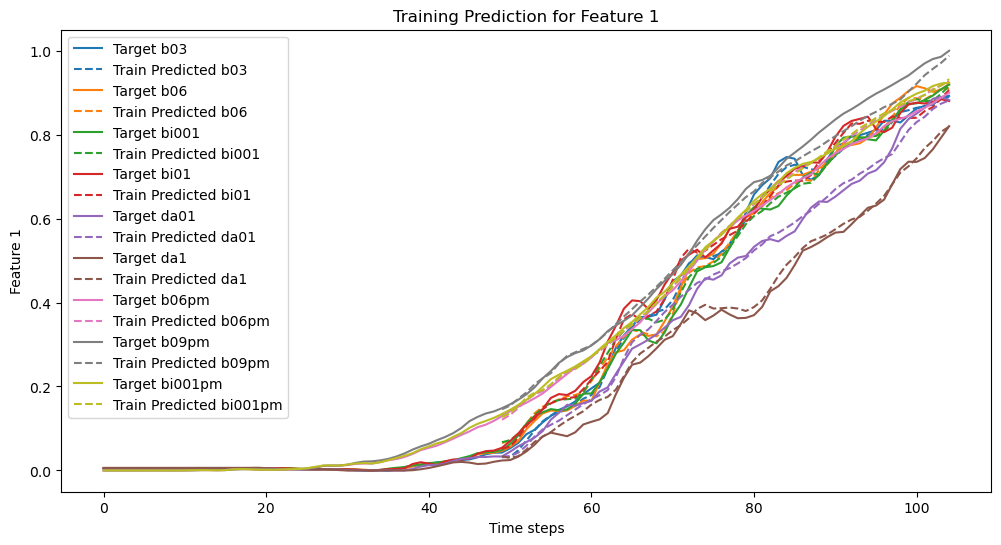

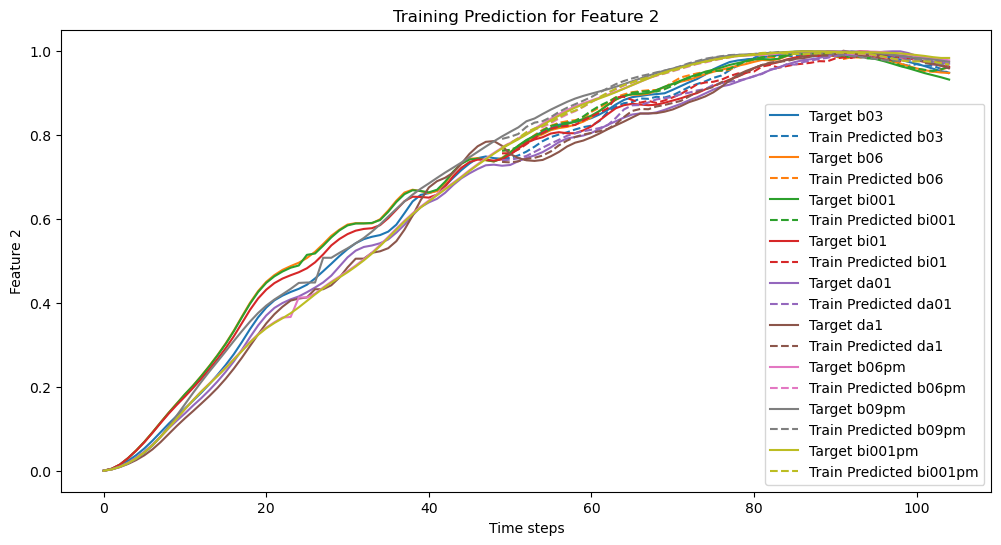

In [64]:
num_features = input_size 
num_seqs = len(train_cases)

# Iterate over each features
for f_idx in range(num_features):
    plt.figure(figsize=(12,6))
    s_idx = -1
    
    for seq, case in zip(range(num_seqs), train_cases):
        # Target for three sequences
        p = plt.plot(train[:, seq, f_idx], label=f'Target {str(case)}')
        
        # Train prediction for multiple sequences
        if seq == 0:
            plt.plot(range(wid_size-1,len(train)),
                     y_pred_train[:train_casebatch[seq],s_idx,f_idx], 
                     c=p[0].get_color(),linestyle='--', label=f'Train Predicted {str(case)}')
        else:
            plt.plot(range(wid_size-1,len(train)),
                     y_pred_train[train_casebatch[seq-1]:train_casebatch[seq],s_idx,f_idx], 
                     c=p[0].get_color(),linestyle='--', label=f'Train Predicted {str(case)}')


    plt.legend()    
    plt.title(f'Training Prediction for Feature {f_idx+1}')
    plt.xlabel('Time steps')
    plt.ylabel(f'Feature {f_idx+1}')
#     plt.savefig(f'lstmmtm_tf03dyS2S_train_{f_idx+1}.png')

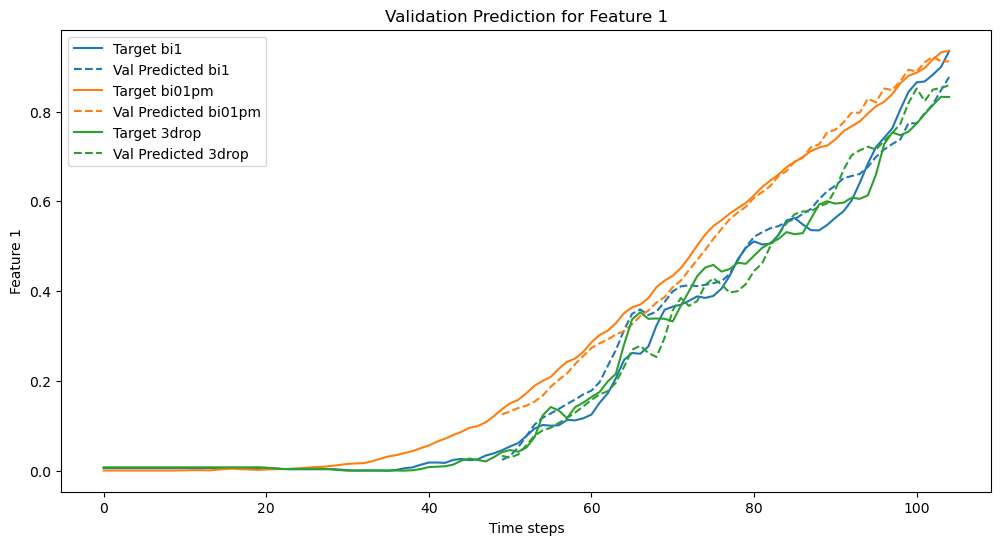

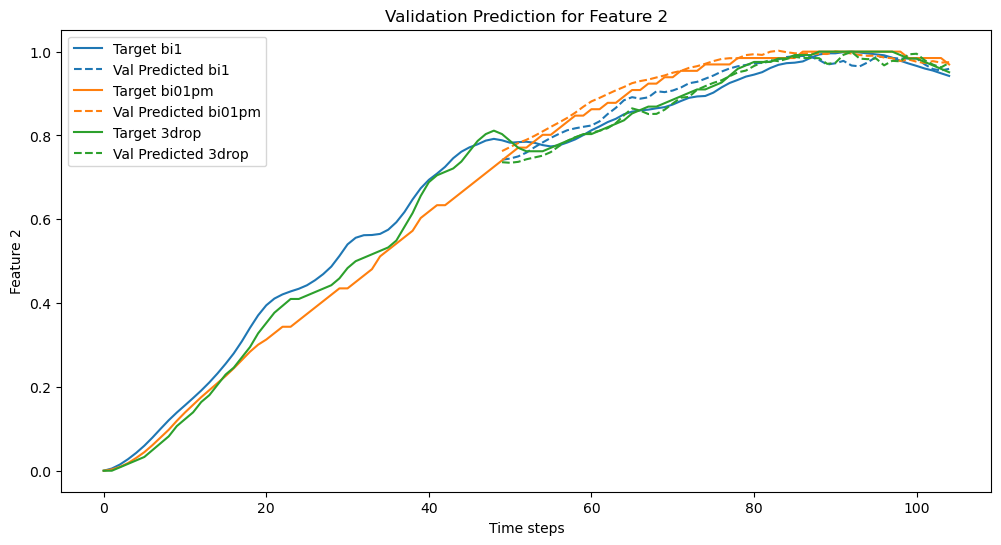

In [65]:
num_features = input_size 
num_seqs = len(val_cases)

# Iterate over each features
for f_idx in range(num_features):
    plt.figure(figsize=(12,6))
    s_idx = -1
    
    for seq, case in zip(range(num_seqs), val_cases):
        # Target for three sequences
        p = plt.plot(val[:, seq, f_idx], label=f'Target {str(case)}')
        
        # validation prediction for multiple sequences
        if seq == 0 :
            plt.plot(range(wid_size-1,len(val)),
                     y_pred_val[:val_casebatch[seq],s_idx,f_idx], 
                     c=p[0].get_color(),linestyle='--', label=f'Val Predicted {str(case)}')
        else:
            plt.plot(range(wid_size-1,len(val)),
                     y_pred_val[val_casebatch[seq-1]:val_casebatch[seq],s_idx,f_idx], 
                     c=p[0].get_color(),linestyle='--', label=f'Val Predicted {str(case)}')

    plt.legend()    
    plt.title(f'Validation Prediction for Feature {f_idx+1}')
    plt.xlabel('Time steps')
    plt.ylabel(f'Feature {f_idx+1}')

In [66]:
# Function to predict future values using rollout with the LSTM model
def rollout(model, input_seq, future_steps):
    model.eval()
    with torch.no_grad():
        
        reshaped_input = np.transpose(input_seq, (1,0,2))
        gen_seq = torch.tensor(reshaped_input).clone().detach()

        num_forwards = int(future_steps / steps_in) + 1
        print(f'prediction iterates for {num_forwards} times.')

        for i in range(num_forwards):
#             input_tensor = torch.tensor([[input_seq[-1]]], dtype=torch.float32)
            input_tensor = torch.tensor(gen_seq.view(reshaped_input.shape[0],-1,input_size), dtype=torch.float32)

            try:
                output = model.predict(input_tensor)
            except:
                output = model(input_tensor)

            gen_seq = torch.cat((torch.tensor(gen_seq), torch.tensor(output)), dim=1)
                

    return gen_seq

In [67]:
input_seq = test[:steps_in,:,:]
future_steps = test.shape[0] - steps_in
rollout_seq = rollout(model, input_seq, future_steps)
print(rollout_seq.shape)

prediction iterates for 4 times.
torch.Size([4, 125, 2])


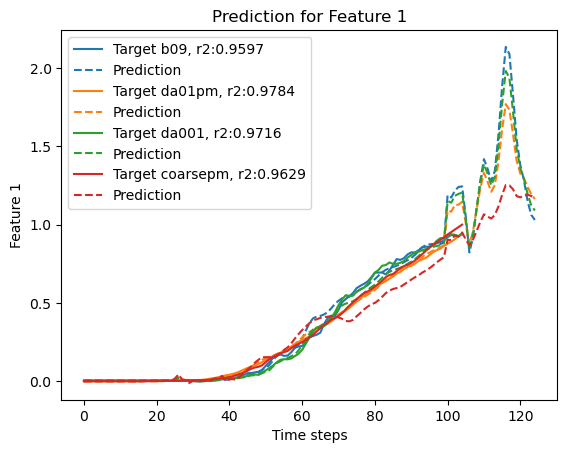

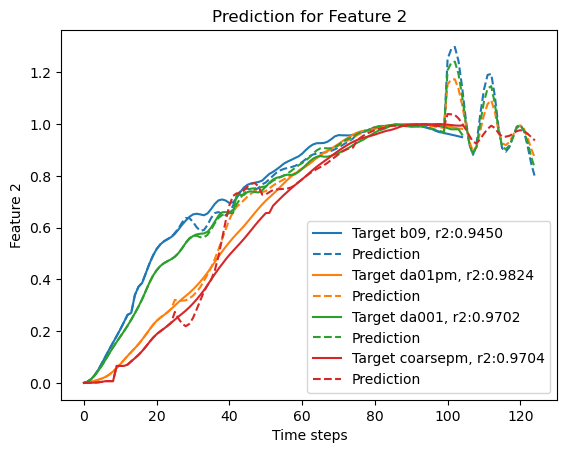

In [68]:
from sklearn.metrics import r2_score
for f_idx in range(input_size):
    plt.figure()
    for i, case in enumerate(test_cases):
        r2 = r2_score(test[:,i,f_idx],rollout_seq[i,:,f_idx][:test.shape[0]])

        p = plt.plot(test[:,i,f_idx], label=f'Target {case}, r2:{r2:.4f}')
        plt.plot(rollout_seq[i,:,f_idx],c=p[0].get_color(), linestyle='--',label=r'Prediction')
    
    plt.legend()    
    plt.title(f'Prediction for Feature {f_idx+1}')
    plt.xlabel('Time steps')
    plt.ylabel(f'Feature {f_idx+1}')

### 2) Sequence-to-Sequence S2S approach
<small> - __Sequence-to-Sequence__: Use the LSTM's output for each time step and feed it back as input for the subsequent time step. In this way, LSTM generates predictions ste-by-step for each future time step. 
